In [45]:
# imports
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import json
import datetime
from datetime import timezone
from datetime import datetime as dt
import numpy as np
import sys
from scipy.stats import pearsonr
from scipy import stats

sys.path.append("../")
from src.utils import *

In [2]:
# polars config
pl.Config.load_from_file("../polars_cfg.json")

# 1. Data loading

Choose whether to include participants that didn't complete all five tasks in the analyses with the True / False toggle.


In [3]:
include_incomplete_data = True

In [6]:
# data file paths
clean_summary_path = "../data/clean_summary_data.csv"
clean_summary_incomplete_path = "../data/clean_summary_data_incomplete.csv"
clean_incomplete_path = "../data/clean_data_incomplete.csv"
clean_all_path = "../data/clean_data.csv"

In [9]:
# load / process data
df_summary = pl.read_csv(clean_summary_path)
df_summary_incomplete = pl.read_csv(clean_summary_incomplete_path)
df_incomplete = pl.read_csv(clean_incomplete_path)
df_all = pl.read_csv(clean_all_path)
columns = [
    "hashed_id",
    "joint_id_task",
    "task_name",
    "task_number",
    "task_type",
    "attempt_number",
    "action",
    "num_actions",
    "solved",
    "time",
    "test_input_grid",
    "test_output_grid",
    "exp_name",
]
if include_incomplete_data:
    df_all = pl.concat([df_all.select(columns), df_incomplete.select(columns)])
    df_summary = pl.concat([df_summary, df_summary_incomplete])

# 2. Data collection results


In [10]:
# unique number of tasks completed in each set
n_training_tasks = df_summary.filter(pl.col("task_type") == "training").n_unique(
    "task_name"
)
n_eval_tasks = df_summary.filter(pl.col("task_type") == "evaluation").n_unique(
    "task_name"
)
print(f"Number of unique training tasks with data: {n_training_tasks}")
print(f"Number of unique evaluation tasks with data: {n_eval_tasks}")

Number of unique training tasks with data: 400
Number of unique evaluation tasks with data: 400


In [11]:
# number of participants in each set
num_participants_training = df_summary.filter(
    pl.col("task_type") == "training"
).n_unique("hashed_id")
num_participants_evaluation = df_summary.filter(
    pl.col("task_type") == "evaluation"
).n_unique("hashed_id")

print(f"Number of participants in training: {num_participants_training}")
print(f"Number of participants in evaluation: {num_participants_evaluation}")
print(
    f"Number of participants in training and evaluation: {num_participants_training + num_participants_evaluation}"
)

Number of participants in training: 783
Number of participants in evaluation: 946
Number of participants in training and evaluation: 1729


In [13]:
# average number of participants per task
mean_participants_per_task = (
    df_summary.group_by("task_name")
    .agg(pl.n_unique("hashed_id").alias("count"), pl.first("task_type"))
    .group_by("task_type")
    .agg(pl.mean("count").alias("mean_count"))
)
print("Average number of participants per task")
print(50 * "-")
print(
    f"Training set: {round(mean_participants_per_task.filter(pl.col('task_type') == 'training').select('mean_count').item(), 1)}"
)
print(
    f"Evaluation set: {round(mean_participants_per_task.filter(pl.col('task_type') == 'evaluation').select('mean_count').item(), 1)}"
)

Average number of participants per task
--------------------------------------------------
Training set: 11.8
Evaluation set: 10.3


In [14]:
print(
    f"Total number of attempts at ARC training tasks: {df_summary.filter(pl.col('task_type') == 'training').height}"
)
print(
    f"Total number of attempts at ARC evaluation tasks: {df_summary.filter(pl.col('task_type') == 'evaluation').height}"
)
print(f"Total number of attepmts on training and evaluation tasks: {df_summary.height}")

Total number of attempts at ARC training tasks: 7924
Total number of attempts at ARC evaluation tasks: 7820
Total number of attepmts on training and evaluation tasks: 15744


In [15]:
print(
    f"Total action traces on ARC training tasks: {df_all.filter(pl.col('task_type') == 'training').height}"
)
print(
    f"Total action traces on ARC evaluation tasks: {df_all.filter(pl.col('task_type') == 'evaluation').height}"
)
print(f"Total action traces on ARC training and evaluation tasks: {df_all.height}")

Total action traces on ARC training tasks: 241697
Total action traces on ARC evaluation tasks: 344569
Total action traces on ARC training and evaluation tasks: 586266


In [16]:
print(
    f"Unique number of visited states in ARC training tasks: {df_all.filter(pl.col('task_type') == 'training').n_unique('test_output_grid')}"
)
print(
    f"Unique number of visited states in ARC evaluation tasks: {df_all.filter(pl.col('task_type') == 'evaluation').n_unique('test_output_grid')}"
)
print(
    f"Unique number of visited states in ARC training and evaluation tasks: {df_all.n_unique('test_output_grid')}"
)

Unique number of visited states in ARC training tasks: 127146
Unique number of visited states in ARC evaluation tasks: 208214
Unique number of visited states in ARC training and evaluation tasks: 334086


# 3. Performance results


In [17]:
# get accuracy results
attempts = [("Three", 4), ("Two", 3), ("One", 2)]
for attempt, attempt_number in reversed(attempts):
    print(f"{attempt} attempt accuracy")
    print(50 * "-")
    mean_task_acc = (
        df_summary.filter(pl.col("attempt_number") < attempt_number)
        .sort(["hashed_id", "task_name", "attempt_number"])
        .group_by(["joint_id_task"])
        .agg(
            pl.any("solved").cast(pl.Int32),
            pl.first("task_type"),
            pl.first("task_name"),
        )
        .group_by("task_name")
        .agg(
            pl.first("task_type"),
            pl.len().alias("count"),
            mean_solved=pl.mean("solved"),
        )
        .sort("mean_solved")
    )
    mean_task_acc.write_csv(f"../data/mean_task_acc_{attempt.lower()}_attempts.csv")
    print(
        f"Training set mean task accuracy: {round(mean_task_acc.filter(pl.col('task_type') == 'training').mean()['mean_solved'][0]*100, 1)}"
    )
    print(
        f"Training set task accuracy std: {round(mean_task_acc.filter(pl.col('task_type') == 'training').std()['mean_solved'][0]*100, 1)}"
    )
    print()
    print(
        f"Evaluation set mean task accuracy: {round(mean_task_acc.filter(pl.col('task_type') == 'evaluation').mean()['mean_solved'][0]*100, 1)}"
    )
    print(
        f"Evaluation set task accuracy std: {round(mean_task_acc.filter(pl.col('task_type') == 'evaluation').std()['mean_solved'][0]*100, 1)}"
    )
    print()

One attempt accuracy
--------------------------------------------------
Training set mean task accuracy: 59.9
Training set task accuracy std: 24.8

Evaluation set mean task accuracy: 47.8
Evaluation set task accuracy std: 23.2

Two attempt accuracy
--------------------------------------------------
Training set mean task accuracy: 72.6
Training set task accuracy std: 22.9

Evaluation set mean task accuracy: 60.2
Evaluation set task accuracy std: 23.3

Three attempt accuracy
--------------------------------------------------
Training set mean task accuracy: 76.2
Training set task accuracy std: 21.5

Evaluation set mean task accuracy: 64.2
Evaluation set task accuracy std: 22.8



In [18]:
# perform t-test on three attempt accuracy between training and evaluation
training_success_rate = (
    mean_task_acc.filter(pl.col("task_type") == "training")
    .select("mean_solved")
    .to_numpy()
    .flatten()
)
evaluation_success_rate = (
    mean_task_acc.filter(pl.col("task_type") == "evaluation")
    .select("mean_solved")
    .to_numpy()
    .flatten()
)

t_stat, p_val = stats.ttest_ind(training_success_rate, evaluation_success_rate)
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.5f}")
print(
    f"Degrees of freedom: {len(training_success_rate) + len(evaluation_success_rate) - 2}"
)

t-statistic: 7.667
p-value: 0.00000
Degrees of freedom: 798


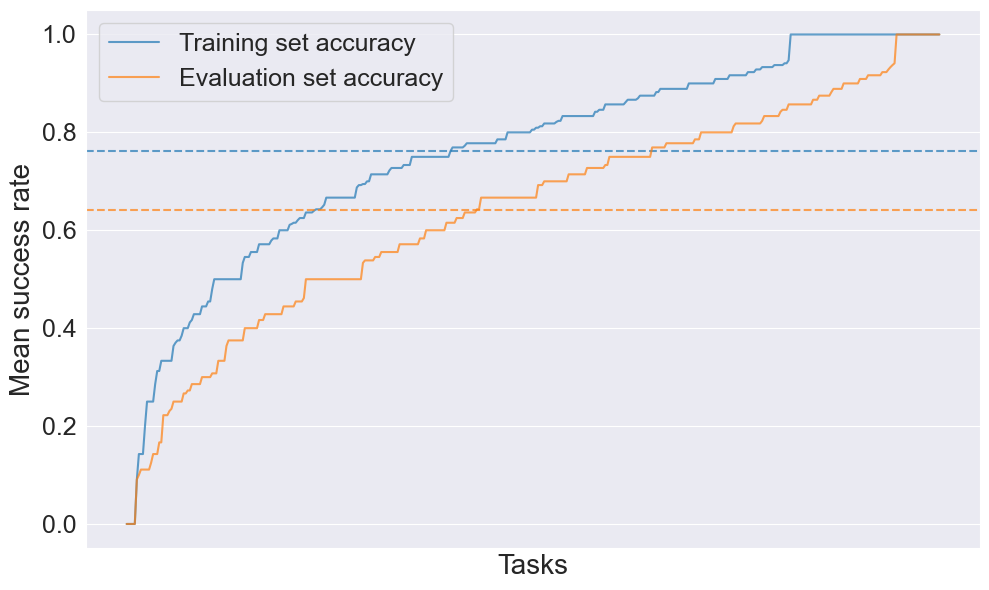

In [19]:
# plot accuracy
sns.set_style("darkgrid")
mean_task_acc = pl.read_csv(f"../data/mean_task_acc_three_attempts.csv")
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
training_set_acc = (
    mean_task_acc.filter(pl.col("task_type") == "training")
    .select(pl.mean("mean_solved"))
    .item()
)
evaluation_set_acc = (
    mean_task_acc.filter(pl.col("task_type") == "evaluation")
    .select(pl.mean("mean_solved"))
    .item()
)
sns.lineplot(
    data=mean_task_acc.filter(pl.col("task_type") == "training").with_row_index(),
    x="index",
    y="mean_solved",
    label="Training set accuracy",
    alpha=0.7,
)
plt.axhline(
    y=training_set_acc,
    color=colors[0],
    linestyle="--",
    alpha=0.7,
)
sns.lineplot(
    data=mean_task_acc.filter(pl.col("task_type") == "evaluation").with_row_index(),
    x="index",
    y="mean_solved",
    alpha=0.7,
    label="Evaluation set accuracy",
)
plt.axhline(
    y=evaluation_set_acc,
    color=colors[1],
    linestyle="--",
    alpha=0.7,
)
plt.xticks([])
plt.yticks(fontsize=18)
plt.ylabel("Mean success rate", fontdict={"fontsize": 20})
plt.xlabel("Tasks", fontdict={"fontsize": 20})
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig("../figures/mean_task_acc.png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
# get best human accuracy for each attempt
def get_best_attempt(df, max_attempts):
    return (
        df.filter(pl.col("attempt_number") <= max_attempts)
        .group_by("task_name")
        .agg(pl.any("solved"), pl.first("task_type"))
    )


def calculate_score(df, task_type):
    filtered_df = df.filter(pl.col("task_type") == task_type)
    solved_count = filtered_df.filter(pl.col("solved")).height
    total_count = filtered_df.height
    return solved_count, total_count


# Calculate best attempts
best_attempts = {
    attempts: get_best_attempt(df_summary, attempts) for attempts in range(1, 4)
}

# Calculate scores
scores = {
    attempts: {
        task_type: calculate_score(df, task_type)
        for task_type in ["training", "evaluation"]
    }
    for attempts, df in best_attempts.items()
}

# Print results
print("Best human performance")
print("-" * 50)
for attempts in range(1, 4):
    print(f"{attempts} attempt{'s' if attempts > 1 else ''}")
    total_solved = 0
    total_count = 0
    for task_type in ["Training", "Evaluation"]:
        solved_count, count = scores[attempts][task_type.lower()]
        total_solved += solved_count
        total_count += count
        percentage = (solved_count / count) * 100
        print(f"{task_type} set: {round(percentage, 1)}% ({solved_count}/{count})")
    total_percentage = (total_solved / total_count) * 100
    print(f"Total: {round(total_percentage, 1)}% ({total_solved}/{total_count})")
    print()

Best human performance
--------------------------------------------------
1 attempt
Training set: 96.8% (387/400)
Evaluation set: 95.8% (383/400)
Total: 96.2% (770/800)

2 attempts
Training set: 98.5% (394/400)
Evaluation set: 97.8% (391/400)
Total: 98.1% (785/800)

3 attempts
Training set: 98.8% (395/400)
Evaluation set: 98.8% (395/400)
Total: 98.8% (790/800)



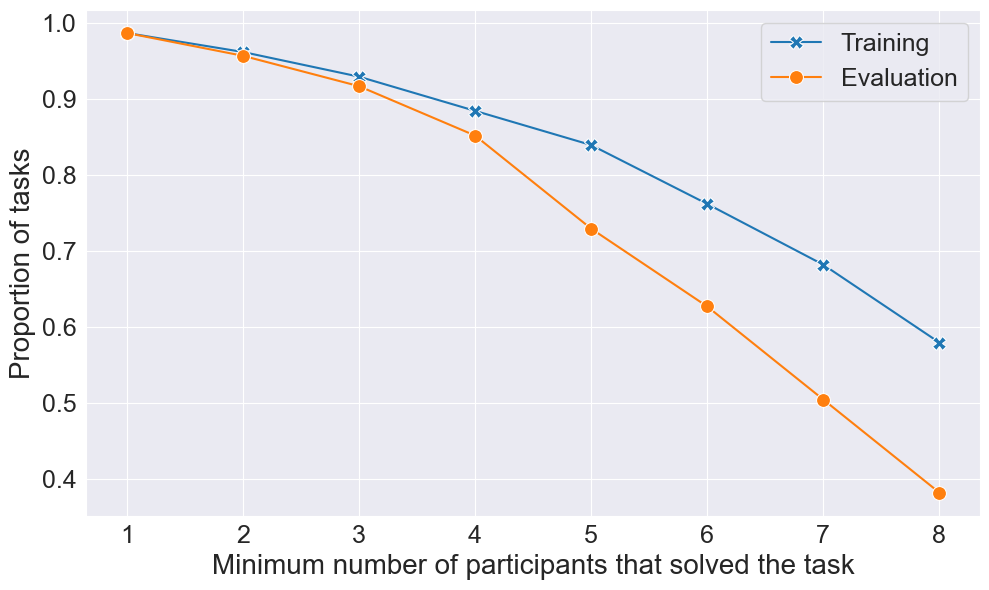

In [21]:
# plot number of tasks solved by 1...9 and more people
solved_by_n_people = df_summary.group_by("task_name").agg(
    pl.count("hashed_id").alias("n_people_attempted"),
    pl.sum("solved").alias("n_solved"),
    pl.first("task_type"),
)

# Create a list to store the data for each n and task type
data = {
    "n": [],
    "task_type": [],
    "task_name": [],
}

for task_type in ["training", "evaluation"]:
    for n in np.arange(1, 9):
        solved_by_n_people_filtered = solved_by_n_people.filter(
            (pl.col("n_solved") >= n) & (pl.col("task_type") == task_type)
        )
        for task_name in (
            solved_by_n_people_filtered.select("task_name")
            .unique()
            .to_numpy()
            .flatten()
        ):
            data["n"].append(n)
            data["task_type"].append(task_type.capitalize())
            data["task_name"].append(task_name)

# Create a DataFrame from the collected data
solved_by_at_least_df = pl.DataFrame(data)
solved_by_at_least_df = solved_by_at_least_df.group_by(["n", "task_type"]).agg(
    pl.count("task_name").alias("proportion") / 400,
)

# Plot using seaborn with hue
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=solved_by_at_least_df,
    x="n",
    y="proportion",
    hue="task_type",
    hue_order=["Training", "Evaluation"],
    style="task_type",
    markers=True,
    dashes=False,
    markersize=10,
)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=18)
plt.ylabel("Proportion of tasks", fontdict={"fontsize": 20})
plt.xlabel(
    "Minimum number of participants that solved the task", fontdict={"fontsize": 20}
)
plt.tight_layout()
plt.savefig("../figures/solved_by_n_people.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
# proportion solved per participant
participants_max_tasks = df_summary.group_by("hashed_id").agg(
    pl.max("task_number"), pl.first("task_type")
)
participants_max_tasks = participants_max_tasks.rename(
    {"task_number": "max_task_number"}
)
df_summary = df_summary.join(participants_max_tasks, on="hashed_id")
proportion_solved = df_summary.group_by("hashed_id").agg(
    pl.sum("solved") / pl.max("max_task_number"), pl.first("task_type")
)

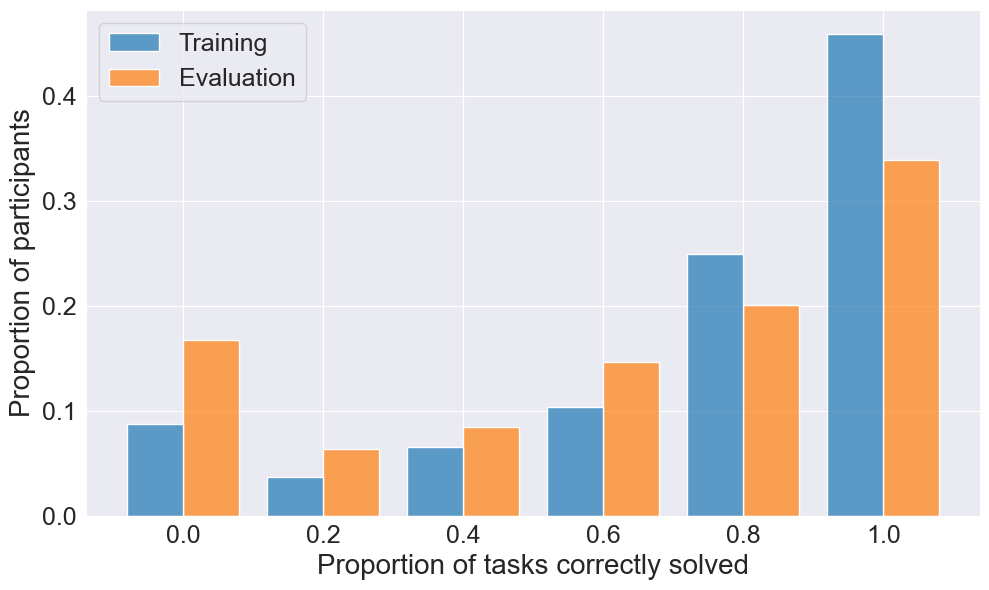

In [23]:
# histplot of proportion of tasks solved
sns.set_style("darkgrid")
ax = plt.subplots(figsize=(10, 6))
hue_order = ["training", "evaluation"]
max_n = proportion_solved.select(pl.max("solved")).item()
min_n = proportion_solved.select(pl.min("solved")).item()
bins = 6
step = (max_n - min_n) / bins
arr_div = np.arange(min_n + step / 2, max_n + step / 2, step=step)
arr_div_r = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
sns.histplot(
    data=proportion_solved,
    x="solved",
    stat="proportion",
    bins=6,
    shrink=0.8,
    alpha=0.7,
    multiple="dodge",
    hue="task_type",
    common_norm=False,
    hue_order=hue_order,
    ax=ax[1],
)
ax[1].set_xlabel("Proportion of tasks correctly solved", fontdict={"fontsize": 20})
ax[1].set_ylabel("Proportion of participants", fontdict={"fontsize": 20})
plt.xticks(arr_div, arr_div_r, fontsize=18)
plt.yticks(fontsize=18)
ax[1].get_legend().set_title("Split")
handles = ax[1].get_legend().legend_handles
plt.legend(handles=handles, labels=["Training", "Evaluation"], fontsize=18)
plt.tight_layout()
plt.savefig("../figures/task_success_dist.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
# particpant success rate stats
def calculate_stats(df, task_type):
    filtered = df.filter(pl.col("task_type") == task_type)
    stats = filtered.select(
        [
            pl.col("solved").mean().alias("mean"),
            pl.col("solved").std().alias("std"),
            pl.col("solved").mode().alias("mode"),
        ]
    )
    perfect = filtered.filter(pl.col("solved") == 1).height
    zero = filtered.filter(pl.col("solved") == 0).height
    total = filtered.height

    print(f"{task_type.capitalize()} set statistics:")
    print("-" * 50)
    print(f"Mean success rate: {round(stats['mean'][0]*100, 1)}%")
    print(f"Std success rate: {round(stats['std'][0]*100, 1)}%")
    print(f"Success rate mode: {round(stats['mode'][0]*100, 1)}%")
    print(f"All tasks solved: {perfect}/{total} ({round(perfect/total*100, 1)}%)")
    print(f"No tasks solved: {zero}/{total} ({round(zero/total*100, 1)}%)\n")


# Calculate and print stats for both sets
for task_type in ["training", "evaluation"]:
    calculate_stats(proportion_solved, task_type)

Training set statistics:
--------------------------------------------------
Mean success rate: 74.2%
Std success rate: 31.2%
Success rate mode: 100.0%
All tasks solved: 314/783 (40.1%)
No tasks solved: 67/783 (8.6%)

Evaluation set statistics:
--------------------------------------------------
Mean success rate: 62.7%
Std success rate: 36.7%
Success rate mode: 100.0%
All tasks solved: 320/946 (33.8%)
No tasks solved: 158/946 (16.7%)



In [25]:
def calculate_accuracy_stats(df, task_type):
    filtered = df.filter(pl.col("task_type") == task_type)
    total = filtered.height

    stats = {
        "perfect": filtered.filter(pl.col("mean_solved") == 1).height,
        "above_80": filtered.filter(pl.col("mean_solved") >= 0.8).height,
        "zero": filtered.filter(pl.col("mean_solved") == 0).height,
    }

    print(f"{task_type.capitalize()} set task statistics:")
    print("-" * 50)
    print(
        f"100% accuracy: {stats['perfect']}/{total} ({stats['perfect']/total*100:.1f}%)"
    )
    print(
        f"80% or more accuracy: {stats['above_80']}/{total} ({stats['above_80']/total*100:.1f}%)"
    )
    print(f"0% accuracy: {stats['zero']}/{total} ({stats['zero']/total*100:.2f}%)\n")


# Calculate and print accuracy stats for both sets
for task_type in ["training", "evaluation"]:
    calculate_accuracy_stats(mean_task_acc, task_type)

Training set task statistics:
--------------------------------------------------
100% accuracy: 74/400 (18.5%)
80% or more accuracy: 213/400 (53.2%)
0% accuracy: 5/400 (1.25%)

Evaluation set task statistics:
--------------------------------------------------
100% accuracy: 22/400 (5.5%)
80% or more accuracy: 118/400 (29.5%)
0% accuracy: 5/400 (1.25%)



In [26]:
# calculate number of mean number of attempts per task
attempts_per_task_mean = (
    df_summary.filter(pl.col("solved"))
    .group_by("task_name")
    .agg(
        pl.mean("attempt_number").alias("mean_attempts"),
        pl.first("task_type"),
    )
    .sort("mean_attempts")
)
attempts_per_task_mode = stats.mode(
    df_summary.filter(pl.col("solved")).select("attempt_number").to_numpy().flatten()
).mode.item()
attempts_per_task_median = np.median(
    df_summary.filter(pl.col("solved")).select("attempt_number").to_numpy().flatten()
)
for task_type in ["training", "evaluation"]:
    print(f"Number of attempts to win per task in {task_type} set")
    print("-" * 50)
    print(
        f"Mean: {round(attempts_per_task_mean.filter(pl.col('task_type') == task_type).mean()['mean_attempts'][0], 1)}"
    )
    print(
        f"Std: {round(attempts_per_task_mean.filter(pl.col('task_type') == task_type).std()['mean_attempts'][0], 1)}"
    )
    # print mode
    print(f"Mode: {attempts_per_task_mode}")
    # print median
    print(f"Median: {attempts_per_task_median}\n")

Number of attempts to win per task in training set
--------------------------------------------------
Mean: 1.3
Std: 0.3
Mode: 1
Median: 1.0

Number of attempts to win per task in evaluation set
--------------------------------------------------
Mean: 1.4
Std: 0.3
Mode: 1
Median: 1.0



# 4. Temporal analyses


In [28]:
df_all = df_all.with_columns(pl.col("time").cast(pl.Datetime))

In [29]:
# time to complete tasks
time_to_complete = (
    df_all.group_by(["joint_id_task"])
    .agg(
        pl.min("time").alias("min_time"),
        pl.max("time").alias("max_time"),
        pl.col("task_name").first(),
        pl.col("hashed_id").first(),
        pl.any("solved"),
        pl.first("task_type"),
        pl.max("attempt_number").alias("max_attempt"),
    )
    .with_columns((pl.col("max_time") - pl.col("min_time")).alias("time_to_complete"))
)
# cast time to complete to seconds
time_to_complete = time_to_complete.with_columns(
    pl.col("time_to_complete")
    .map_elements(lambda x: x.total_seconds(), return_dtype=pl.Float64)
    .alias("seconds_to_complete")
)

In [31]:
# time to complete stats
def format_time(seconds):
    return dt.fromtimestamp(seconds, tz=timezone.utc).strftime("%H:%M:%S")


def calculate_time_stats(df, task_type, solved_only=False):
    filtered = df.filter(pl.col("task_type") == task_type)
    if solved_only:
        filtered = filtered.filter(pl.col("solved"))

    stats = filtered.select(
        [
            pl.col("time_to_complete").mean().alias("mean_time"),
            pl.col("seconds_to_complete").std().alias("std_time"),
        ]
    )

    mean_time = stats["mean_time"][0]
    std_time = format_time(stats["std_time"][0])

    solved_str = " (solved only)" if solved_only else ""
    print(f"{task_type.capitalize()} tasks{solved_str}:")
    print("-" * 50)
    print(f"Mean time to complete: {mean_time}")
    print(f"Std time to complete: {std_time}\n")


# Calculate time stats for all tasks
for task_type in ["training", "evaluation"]:
    calculate_time_stats(time_to_complete, task_type)

# Normalize time by number of attempts
time_to_complete_norm = time_to_complete.with_columns(
    pl.col("time_to_complete") / pl.col("max_attempt")
)

# Calculate time stats for solved tasks
for task_type in ["training", "evaluation"]:
    calculate_time_stats(time_to_complete_norm, task_type, solved_only=True)

Training tasks:
--------------------------------------------------
Mean time to complete: 0:04:19.846812
Std time to complete: 00:04:04

Evaluation tasks:
--------------------------------------------------
Mean time to complete: 0:06:39.484233
Std time to complete: 00:05:59

Training tasks (solved only):
--------------------------------------------------
Mean time to complete: 0:03:07.395602
Std time to complete: 00:03:29

Evaluation tasks (solved only):
--------------------------------------------------
Mean time to complete: 0:04:31.342815
Std time to complete: 00:04:54



In [32]:
# normalize time by number of attempts
time_to_complete_norm = time_to_complete.with_columns(
    pl.col("time_to_complete") / pl.col("max_attempt")
)

In [33]:
def perform_t_test(df, task_type, solved_only=None):
    filter_cond = (pl.col("task_type") == task_type) & pl.col(
        "seconds_to_complete"
    ).is_not_null()
    if solved_only:
        filter_cond &= pl.col("solved")

    times = df.filter(filter_cond).select("seconds_to_complete").to_numpy().flatten()
    return times


def print_t_test_results(train_times, eval_times, test_type):
    t_stat, p_val = stats.ttest_ind(train_times, eval_times)
    df = len(train_times) + len(eval_times) - 2

    print(
        f"Independent samples t-test between training and evaluation set task times ({test_type}):"
    )
    print(f"t-statistic: {round(t_stat, 4)}")
    print(f"p-value: {round(p_val, 4)}")
    print(f"Degrees of freedom: {df}\n")


for test_type, condition in [
    ("solved attempts", "solved"),
    ("all attempts", None),
]:
    train_times = perform_t_test(time_to_complete_norm, "training", condition)
    eval_times = perform_t_test(time_to_complete_norm, "evaluation", condition)
    print_t_test_results(train_times, eval_times, test_type)

Independent samples t-test between training and evaluation set task times (solved attempts):
t-statistic: -17.6711
p-value: 0.0
Degrees of freedom: 6268

Independent samples t-test between training and evaluation set task times (all attempts):
t-statistic: -21.6316
p-value: 0.0
Degrees of freedom: 8874



In [34]:
def calculate_exp_time_stats(df, task_type):
    filtered = df.filter(pl.col("task_type") == task_type)
    stats = filtered.select(
        [
            pl.col("time_to_complete").mean().alias("mean"),
            pl.col("seconds_to_complete").std().alias("std"),
            pl.col("seconds_to_complete").min().alias("min"),
            pl.col("time_to_complete").max().alias("max"),
        ]
    )

    print(f"\n{task_type.capitalize()} set experiment:")
    print(50 * "-")
    print(f"Mean time to complete: {stats['mean'][0]}")
    print(f"Time to complete std: {format_time(stats['std'][0])}")
    print(f"Min time to complete: {format_time(stats['min'][0])}")
    print(f"Max time to complete: {stats['max'][0]}")


# Prepare the data
time_to_complete_exp = (
    df_all.filter(~pl.col("exp_name").str.contains_any(["expv0", "expv1"]))
    .group_by(["hashed_id"])
    .agg(
        pl.min("time").alias("min_time"),
        pl.max("time").alias("max_time"),
        pl.first("task_type"),
    )
    .with_columns(
        (pl.col("max_time") - pl.col("min_time")).alias("time_to_complete"),
    )
    .with_columns(
        pl.col("time_to_complete")
        .map_elements(lambda x: x.total_seconds(), return_dtype=pl.Float64)
        .alias("seconds_to_complete"),
    )
    .select("time_to_complete", "seconds_to_complete", "task_type")
)

# Calculate and print stats for both sets
for task_type in ["training", "evaluation"]:
    calculate_exp_time_stats(time_to_complete_exp, task_type)


Training set experiment:
--------------------------------------------------
Mean time to complete: 0:23:01.776951
Time to complete std: 00:13:24
Min time to complete: 00:00:39
Max time to complete: 1:54:11

Evaluation set experiment:
--------------------------------------------------
Mean time to complete: 0:28:51.588983
Time to complete std: 00:16:19
Min time to complete: 00:02:48
Max time to complete: 2:44:25


In [35]:
# time to first action data
first_second_action = df_all.select(
    pl.all()
    .bottom_k_by("num_actions", k=2)
    .over(["joint_id_task", "attempt_number"], mapping_strategy="explode")
).sort(["joint_id_task", "attempt_number", "num_actions"])
time_to_first_action = (
    first_second_action.group_by(
        ["joint_id_task", "attempt_number"], maintain_order=True
    )
    .agg(
        pl.last("action"),
        pl.min("time").alias("min_time"),
        pl.max("time").alias("max_time"),
        pl.first("task_name"),
        pl.first("task_type"),
    )
    .with_columns(
        (pl.col("max_time") - pl.col("min_time")).alias("time_to_first_action")
    )
)
time_to_first_action.with_columns(
    pl.col("time_to_first_action").map_elements(
        lambda x: x.total_seconds(), return_dtype=pl.Float64
    )
).write_csv("../data/time_to_first_action.csv")

In [47]:
# time to first action stats
for task_type in ["training", "evaluation"]:
    print(f"Time to first action for {task_type} set")
    print(50 * "-")
    for attempt_number in range(1, 4):
        # time to first action on attempt_number
        mean_time_to_first_action = (
            time_to_first_action.filter(
                (pl.col("attempt_number") == attempt_number)
                & (pl.col("task_type") == task_type)
            )
            .select(pl.mean("time_to_first_action"))
            .item()
        )

        time_to_first_action = time_to_first_action.with_columns(
            pl.col("time_to_first_action")
            .map_elements(lambda x: x.total_seconds(), return_dtype=pl.Float64)
            .alias("seconds_to_first_action")
        )
        std_time_to_first_action = (
            time_to_first_action.filter(pl.col("attempt_number") == attempt_number)
            .select(pl.std("seconds_to_first_action"))
            .item()
        )
        std_time_to_first_action = dt.fromtimestamp(
            std_time_to_first_action, tz=timezone.utc
        ).strftime("%H:%M:%S")
        print(
            f"Mean time to first action on attempt {attempt_number}: {mean_time_to_first_action}"
        )
        print(
            f"Time to first action std on attempt {attempt_number}: {std_time_to_first_action}\n"
        )

Time to first action for training set
--------------------------------------------------
Mean time to first action on attempt 1: 0:00:40.418599
Time to first action std on attempt 1: 00:01:24

Mean time to first action on attempt 2: 0:00:05.339852
Time to first action std on attempt 2: 00:00:47

Mean time to first action on attempt 3: 0:00:07.694810
Time to first action std on attempt 3: 00:00:13

Time to first action for evaluation set
--------------------------------------------------
Mean time to first action on attempt 1: 0:00:46.371302
Time to first action std on attempt 1: 00:01:24

Mean time to first action on attempt 2: 0:00:07.781826
Time to first action std on attempt 2: 00:00:47

Mean time to first action on attempt 3: 0:00:04.001870
Time to first action std on attempt 3: 00:00:13



In [48]:
# inter-action time
df_all_time_diff = df_all.sort(
    by=["joint_id_task", "attempt_number", "num_actions"]
).with_columns(
    inter_action_time=pl.col("time")
    .diff()
    .over(["joint_id_task", "attempt_number"])
    .map_elements(lambda x: x.total_seconds(), return_dtype=pl.Float64)
)
# proxy for thinking time accounting for any interval longer than 5seconds and not including writing time
df_all_thinking_time = df_all_time_diff.filter((pl.col("inter_action_time") >= 5))
df_all_thinking_time = df_all_thinking_time.group_by(["joint_id_task"]).agg(
    pl.sum("inter_action_time").alias("thinking_time"),
    pl.first("task_name"),
    pl.first("task_type"),
    pl.any("solved"),
    pl.max("attempt_number").alias("max_attempt"),
)
writing_time = df_all_time_diff.filter(
    (pl.col("inter_action_time") >= 5)
    & (
        pl.col("action").is_in(
            [
                "write_first_description",
                "write_last_description",
                "no_last_description",
                "submit",
            ]
        )
    )
)
writing_time = writing_time.group_by(["joint_id_task"]).agg(
    pl.sum("inter_action_time").alias("writing_time"),
)
df_all_thinking_time = df_all_thinking_time.join(
    writing_time, on="joint_id_task", how="inner"
)
df_all_thinking_time = df_all_thinking_time.with_columns(
    (pl.col("thinking_time") - pl.col("writing_time")) / pl.col("max_attempt")
)

In [49]:
# print mean thinking type for each dataset for solved attempts
for task_type in ["training", "evaluation"]:
    print(f"Mean thinking time for {task_type} set")
    print(50 * "-")
    mean_thinking_time = (
        df_all_thinking_time.filter(
            (pl.col("task_type") == task_type) & pl.col("solved")
        )
        .select(pl.mean("thinking_time"))
        .item()
    )
    # convert to H:M:S
    mean_thinking_time = dt.fromtimestamp(mean_thinking_time, tz=timezone.utc).strftime(
        "%H:%M:%S"
    )
    std_thinking_time = (
        df_all_thinking_time.filter(
            (pl.col("task_type") == task_type) & pl.col("solved")
        )
        .select(pl.std("thinking_time"))
        .item()
    )
    std_thinking_time = dt.fromtimestamp(std_thinking_time, tz=timezone.utc).strftime(
        "%H:%M:%S"
    )
    print(f"Normalized mean thinking time for solved tasks: {mean_thinking_time}")
    print(f"Normalized std thinking time for solved tasks: {std_thinking_time}\n")
    print()

Mean thinking time for training set
--------------------------------------------------
Normalized mean thinking time for solved tasks: 00:01:06
Normalized std thinking time for solved tasks: 00:01:10


Mean thinking time for evaluation set
--------------------------------------------------
Normalized mean thinking time for solved tasks: 00:01:37
Normalized std thinking time for solved tasks: 00:01:39




In [50]:
# perform independent samples t-test between training and evaluation set
train_thinking_times = (
    df_all_thinking_time.filter(
        (pl.col("task_type") == "training")
        & pl.col("thinking_time").is_not_null()
        & pl.col("solved")
    )
    .select("thinking_time")
    .to_numpy()
    .flatten()
)
eval_thinking_times = (
    df_all_thinking_time.filter(
        (pl.col("task_type") == "evaluation")
        & pl.col("thinking_time").is_not_null()
        & pl.col("solved")
    )
    .select("thinking_time")
    .to_numpy()
    .flatten()
)

t_stat, p_val = stats.ttest_ind(train_thinking_times, eval_thinking_times)
print(
    f"Independent samples t-test between training and evaluation set thinking times on solved tasks:"
)
print(f"t-statistic: {round(t_stat, 4)}")
print(f"p-value: {round(p_val, 4)}")
print(f"Degrees of freedom: {len(train_thinking_times) + len(eval_thinking_times) - 2}")

Independent samples t-test between training and evaluation set thinking times on solved tasks:
t-statistic: -6.9061
p-value: 0.0
Degrees of freedom: 1505


# 5. Actions


In [51]:
# calculate proportion of first actions changing grid dimensions
def calculate_change_dim_proportion(df, task_type=None):
    filtered_df = df.filter(pl.col("task_type") == task_type) if task_type else df
    action_counts = (
        filtered_df.group_by("action")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    action_counts = action_counts.with_columns(
        pl.col("count") / action_counts.select(pl.sum("count")).item()
    )
    change_dim_proportion = (
        action_counts.filter(pl.col("action").is_in(["change_height", "change_width"]))
        .select(pl.sum("count"))
        .item()
    )
    return change_dim_proportion


change_dim_training = calculate_change_dim_proportion(time_to_first_action, "training")
change_dim_eval = calculate_change_dim_proportion(time_to_first_action, "evaluation")
change_dim_all = calculate_change_dim_proportion(time_to_first_action)

print(f"Proportion of first actions changing grid dimensions:")
print(f"Training set: {change_dim_training*100:.2f}%")
print(f"Evaluation set: {change_dim_eval*100:.2f}%")
print(f"Mean across both datasets: {change_dim_all*100:.2f}%")

Proportion of first actions changing grid dimensions:
Training set: 34.34%
Evaluation set: 32.13%
Mean across both datasets: 33.23%


# 6. Grid size and difficulty


In [52]:
arc_grid_size = pl.read_csv("../data/ARC_all_tasks_tests_stats.csv")
task_stats = mean_task_acc.join(
    arc_grid_size.drop("task_type"), on="task_name", how="inner"
)

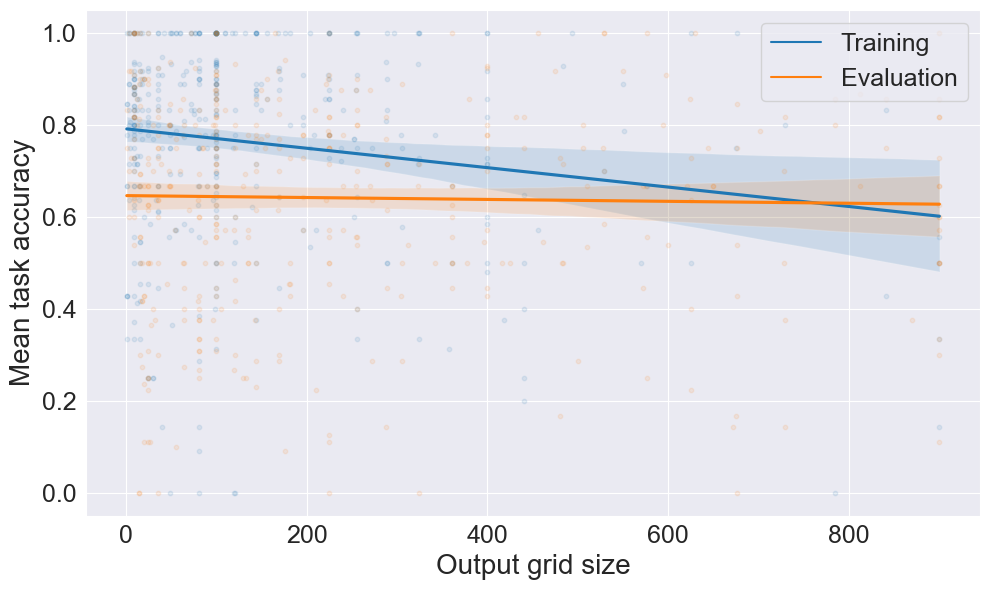

In [53]:
# plot regression of mean task accuracy vs grid size
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(
    data=task_stats.filter(pl.col("task_type") == "training"),
    x="grid_size",
    y="mean_solved",
    scatter_kws={"alpha": 0.1, "s": 10},
    ax=ax,
    label="Training",
)
sns.regplot(
    data=task_stats.filter(pl.col("task_type") == "evaluation"),
    x="grid_size",
    y="mean_solved",
    scatter_kws={"alpha": 0.1, "s": 10},
    ax=ax,
    label="Evaluation",
)
# plt.title("Mean task accuracy vs grid size", fontsize=18)
ax.set_xlabel("Output grid size", fontsize=20)
ax.set_ylabel("Mean task accuracy", fontsize=20)
color_palette = sns.color_palette("tab10")
line_training = Line2D(
    [0],
    [0],
    label="Training",
    color=color_palette[0],
)
line_evaluation = Line2D(
    [0],
    [0],
    label="Evaluation",
    color=color_palette[1],
)
handles = [line_training, line_evaluation]
labels = ["Training", "Evaluation"]
plt.legend(handles=handles, labels=labels, fontsize=18, loc="upper right")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(
    "../figures/mean_task_accuracy_vs_grid_size.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [54]:
# correlation between grid size and mean task accuracy
def calculate_correlation(data, task_type):
    x = (
        data.filter(pl.col("task_type") == task_type)
        .select("grid_size")
        .to_numpy()
        .flatten()
    )
    y = (
        data.filter(pl.col("task_type") == task_type)
        .select("mean_solved")
        .to_numpy()
        .flatten()
    )
    corr, p_value = pearsonr(x, y)
    print(
        f"Pearson correlation coefficient on {task_type} set: {corr:.2f} (p-value: {p_value:.3f})"
    )


calculate_correlation(task_stats, "evaluation")
calculate_correlation(task_stats, "training")

Pearson correlation coefficient on evaluation set: -0.02 (p-value: 0.649)
Pearson correlation coefficient on training set: -0.16 (p-value: 0.001)


# 7. Learning

Make task success dataframe for further analyses in R.


In [55]:
# let's gather the data
task_success = df_all.select("hashed_id", "joint_id_task", "task_number", "solved")
task_success = (
    task_success.group_by("joint_id_task")
    .agg(
        pl.first("hashed_id"),
        pl.first("task_number"),
        pl.any("solved").alias("success"),
    )
    .drop("joint_id_task")
)
task_success = task_success.with_columns(
    success=pl.col("success").cast(pl.Int32),
    hashed_id=pl.col("hashed_id").cast(pl.Categorical),
)
task_success = task_success.with_columns(task_number=pl.col("task_number") - 1).filter(
    (pl.col("task_number") > 0)
)
task_success.head()

hashed_id,task_number,success
cat,i64,i32
"""af9bf0ddc3abdff8b566e97216d41dd6""",3,1
"""52ee40be8a924388676b8f310d8cd910""",1,0
"""12f27871246e06146bb8d78afb44162e""",8,1
"""2efbb02f2320d55d30a5633b2f40bdc6""",1,1
"""87710a82e147a65a756d6428792f4bdb""",4,1


In [56]:
# save task_num_success
task_success.write_csv("../data/task_number_outcomes.csv")